In [1]:
library(tidyverse) |> suppressMessages()
library(repr) |> suppressMessages()
library(tidymodels) |> suppressMessages()
library(cowplot) |> suppressMessages()
options(repr.matrix.max.rows = 6)
#source('tests.R')
#source("cleanup.R")

# Prediction to the risk of heart attack 

### INTRODUCTION
Heart attack happens when a part of the heart muscle doesn’t get enough blood. Nowadays, heart attack is a common and deadly disease across the world. Every year millions of people suffer from heart attacks that often result in death. If we can predict someone's susceptibility to heart failure in advance, we may be able to take preventative measures and save their life!

In this project, we are trying to predict whether or not someone has a high risk of getting a heart attack. We will analyze a dataset with various factors that may influence the risks of getting heart attack. The Hungarian heart attack data is imported from UCI machine learning repository, written in .tsv format, containing 294 rows and 14 columns. One of the variables, which is “num”, is what we are trying to predict. The values of the “num” column are either 1 (high risk) or 0 (low risk). Our main research question is: **At what values of the predictors do patients have the lowest risk of heart attack, and which of our 5 predictors results in the largest increase in heart attack risk for a small deviation from this low?**

### Preliminary exploratory data analysis

We read the raw data, add column names and remove columns and rows that have missing values. We then split our (now tidy) data into training and testing sets (the latter of which we don't touch afterwards), and select our predictors and class. We make summary tables for our predictors, as well as count the frequencies of our two class values (num=0 and 1). Finally, we make some scatter plots and histograms to help vizualize and interpret our data.

##### Cleaning and tidying our data

In [2]:
heart_attack_data_raw = read_delim("https://raw.githubusercontent.com/RichardAdhika22/group115/main/processed.hungarian%20(1).data",delim=","
                                ,col_names=FALSE) |> suppressMessages()
colnames(heart_attack_data_raw) = c('age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num')
heart_attack_data_tidy = select(heart_attack_data_raw,-slope,-ca,-thal)
heart_attack_data_tidy = filter_all(heart_attack_data_tidy,all_vars(.!="?"))
heart_attack_data_tidy = mutate_if(heart_attack_data_tidy, is.character,as.numeric) |> mutate(num = as.factor(num)) |> mutate(sex = as.factor(sex))

heart_attack_data_tidy


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,1,2,130,132,0,2,185,0,0,0
29,1,2,120,243,0,0,160,0,0,0
30,0,1,170,237,0,1,170,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,1
58,0,2,180,393,0,0,110,1,1,1
65,1,4,130,275,0,1,115,1,1,1


##### Splitting the data into training and testing data

In [3]:
heart_attack_split = initial_split(heart_attack_data_tidy, prop = 0.75, strata = num)
heart_attack_training = training(heart_attack_split)
heart_attack_testing = testing(heart_attack_split)

In [4]:
heart_attack_data_selected = heart_attack_training |>
    select(age,trestbps,chol,thalach,oldpeak,num)

heart_attack_data_selected

age,trestbps,chol,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,130,132,185,0,0
29,120,243,160,0,0
30,170,237,170,0,0
⋮,⋮,⋮,⋮,⋮,⋮
56,155,342,150,3,1
58,180,393,110,1,1
65,130,275,115,1,1


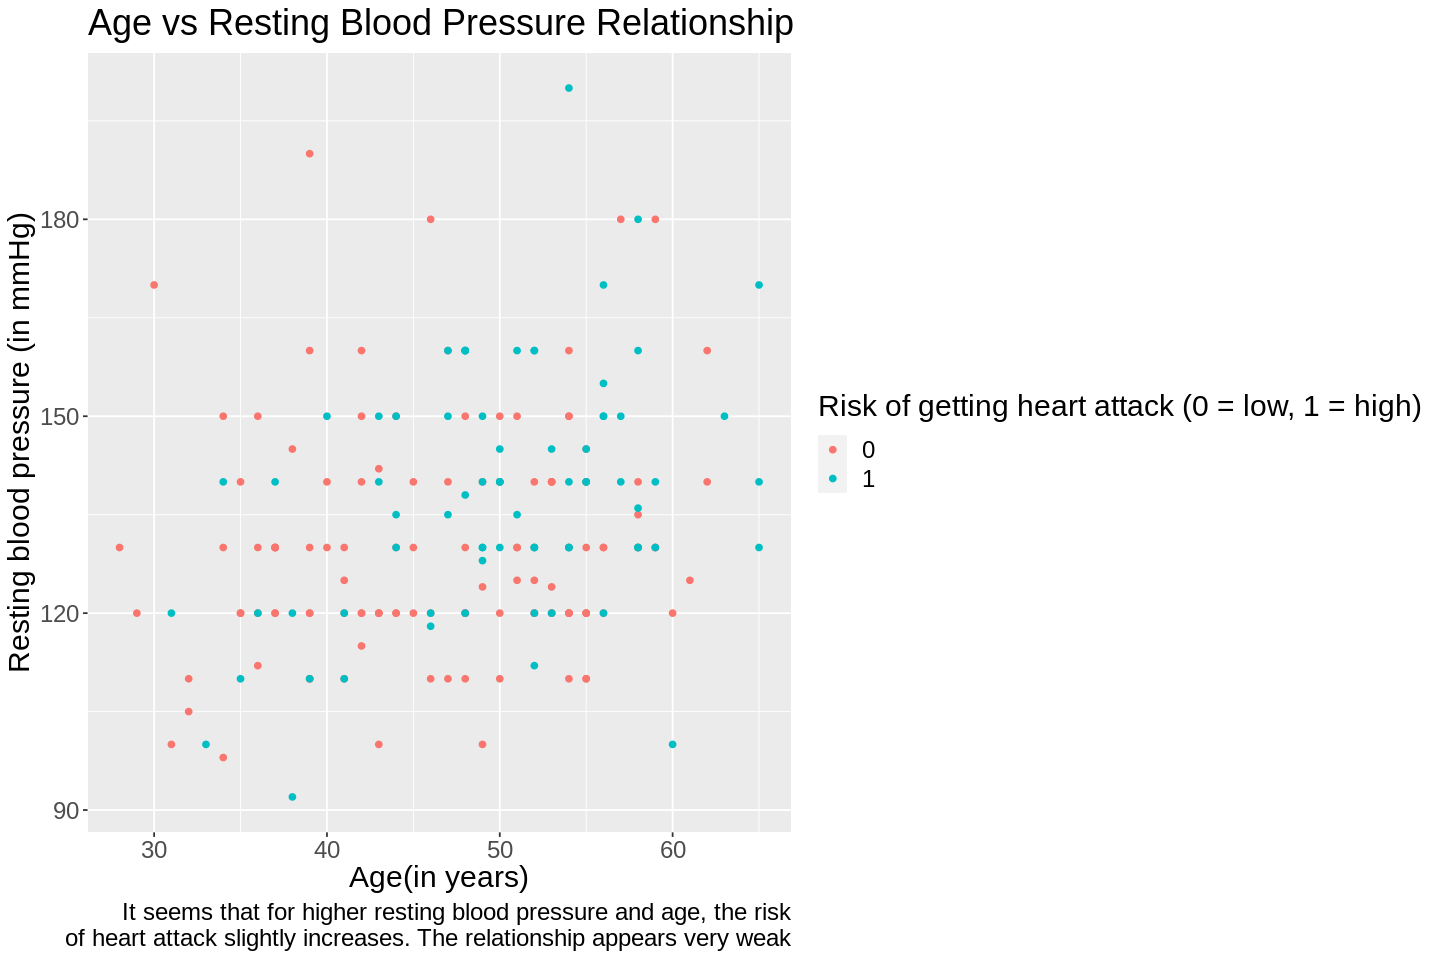

In [5]:
options(repr.plot.width=12, repr.plot.height=8)

age_vs_trestbps = ggplot(heart_attack_data_selected,aes(x=age,y=trestbps,color=num))+
    geom_point() +
    labs(x = "Age(in years)",y = "Resting blood pressure (in mmHg)",
         color = "Risk of getting heart attack (0 = low, 1 = high)",
         caption="It seems that for higher resting blood pressure and age, the risk
                  of heart attack slightly increases. The relationship appears very weak")+
    ggtitle("Age vs Resting Blood Pressure Relationship")+
    theme(text = element_text(size=18))

age_vs_trestbps

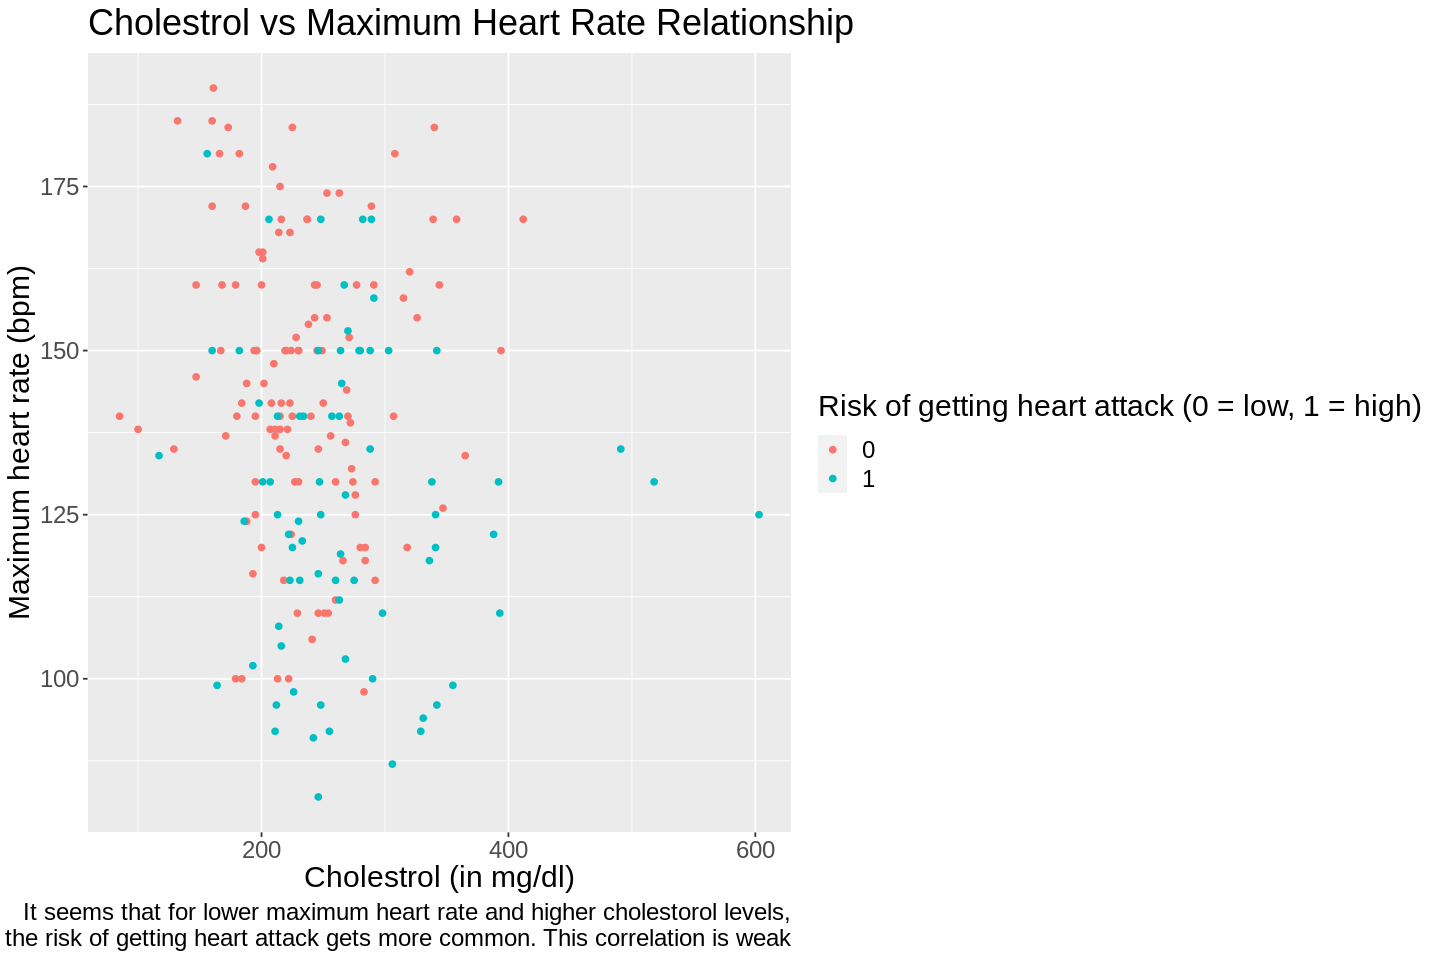

In [6]:
chol_vs_thalach = ggplot(heart_attack_data_selected,aes(x = chol,y = thalach,color=num))+
    geom_point() +
    labs(x = "Cholestrol (in mg/dl)", y = "Maximum heart rate (bpm)",
         color = "Risk of getting heart attack (0 = low, 1 = high)",
         caption="It seems that for lower maximum heart rate and higher cholestorol levels,
                the risk of getting heart attack gets more common. This correlation is weak") +
    ggtitle("Cholestrol vs Maximum Heart Rate Relationship")+
    theme(text = element_text(size=18))

chol_vs_thalach

##### Average of each predictor variables

In [7]:
table_means = heart_attack_data_selected |>
    group_by(num) |>
    summarize(across(age:oldpeak,.fns=list('mean'=mean,'sd'=sd)))

table_means

num,age_mean,age_sd,trestbps_mean,trestbps_sd,chol_mean,chol_sd,thalach_mean,thalach_sd,oldpeak_mean,oldpeak_sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,46.67213,8.282654,130.0410,17.24610,234.3115,56.37054,144.9918,21.94301,0.1868852,0.4927492
1,49.97260,7.770980,138.0685,19.01705,270.5205,79.34036,126.1644,23.23851,1.4041096,1.1138570


##### Amount of each class

In [8]:
total_amount = heart_attack_data_selected |>
    summarize("total"=n())|>
    pull()

table_num_count = heart_attack_data_selected |>
    group_by(num) |>
    summarize("total_number_of_num" = n())|>
    mutate("percentage" = total_number_of_num/total_amount*100)

table_num_count 

num,total_number_of_num,percentage
<fct>,<int>,<dbl>
0,122,62.5641
1,73,37.4359


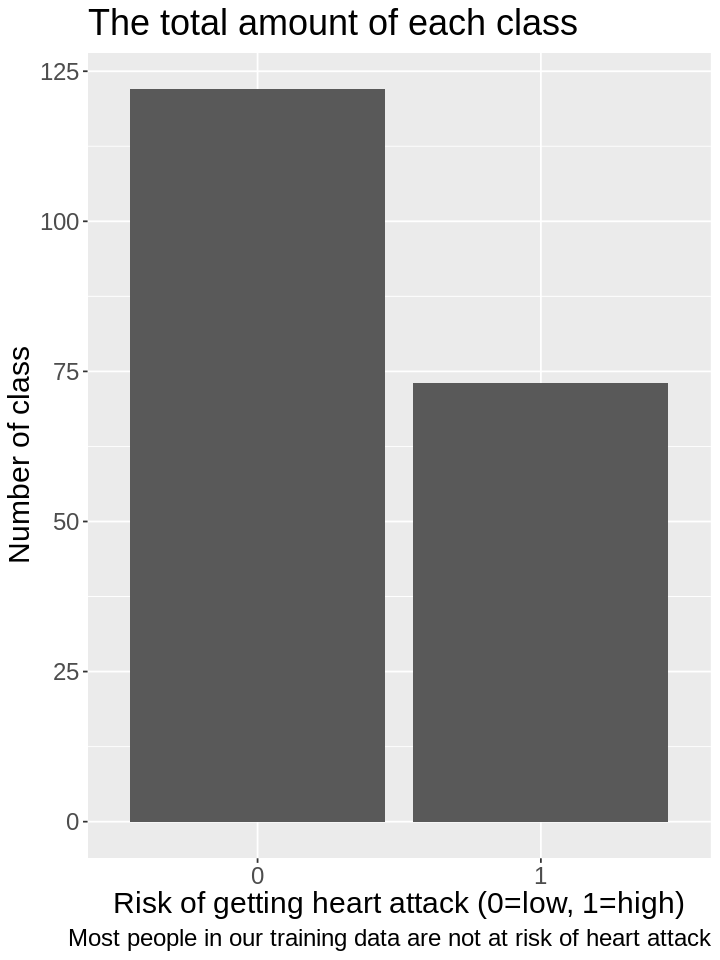

In [9]:
options(repr.plot.width=6, repr.plot.height=8)

num_count_plot = table_num_count |>
    ggplot(aes(x = num, y = total_number_of_num))+
    geom_bar(stat="identity")+
    labs(x = "Risk of getting heart attack (0=low, 1=high)", y = "Number of class",caption='Most people in our training data are not at risk of heart attack')+
    ggtitle("The total amount of each class")+
    theme(text = element_text(size=18))

num_count_plot

### The number of omitted observations

In [10]:
missing_data = nrow(heart_attack_data_raw) - nrow(heart_attack_data_tidy)
missing_data

[1] 33

In [11]:
value_count = pull(table_num_count, total_number_of_num)

summary_table = bind_cols(table_means,value_count) |> suppressMessages()
names(summary_table)[names(summary_table) == '...12'] <- 'total_number_of_num'
summary_table

num,age_mean,age_sd,trestbps_mean,trestbps_sd,chol_mean,chol_sd,thalach_mean,thalach_sd,oldpeak_mean,oldpeak_sd,total_number_of_num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,46.67213,8.282654,130.0410,17.24610,234.3115,56.37054,144.9918,21.94301,0.1868852,0.4927492,122
1,49.97260,7.770980,138.0685,19.01705,270.5205,79.34036,126.1644,23.23851,1.4041096,1.1138570,73


### Distributions

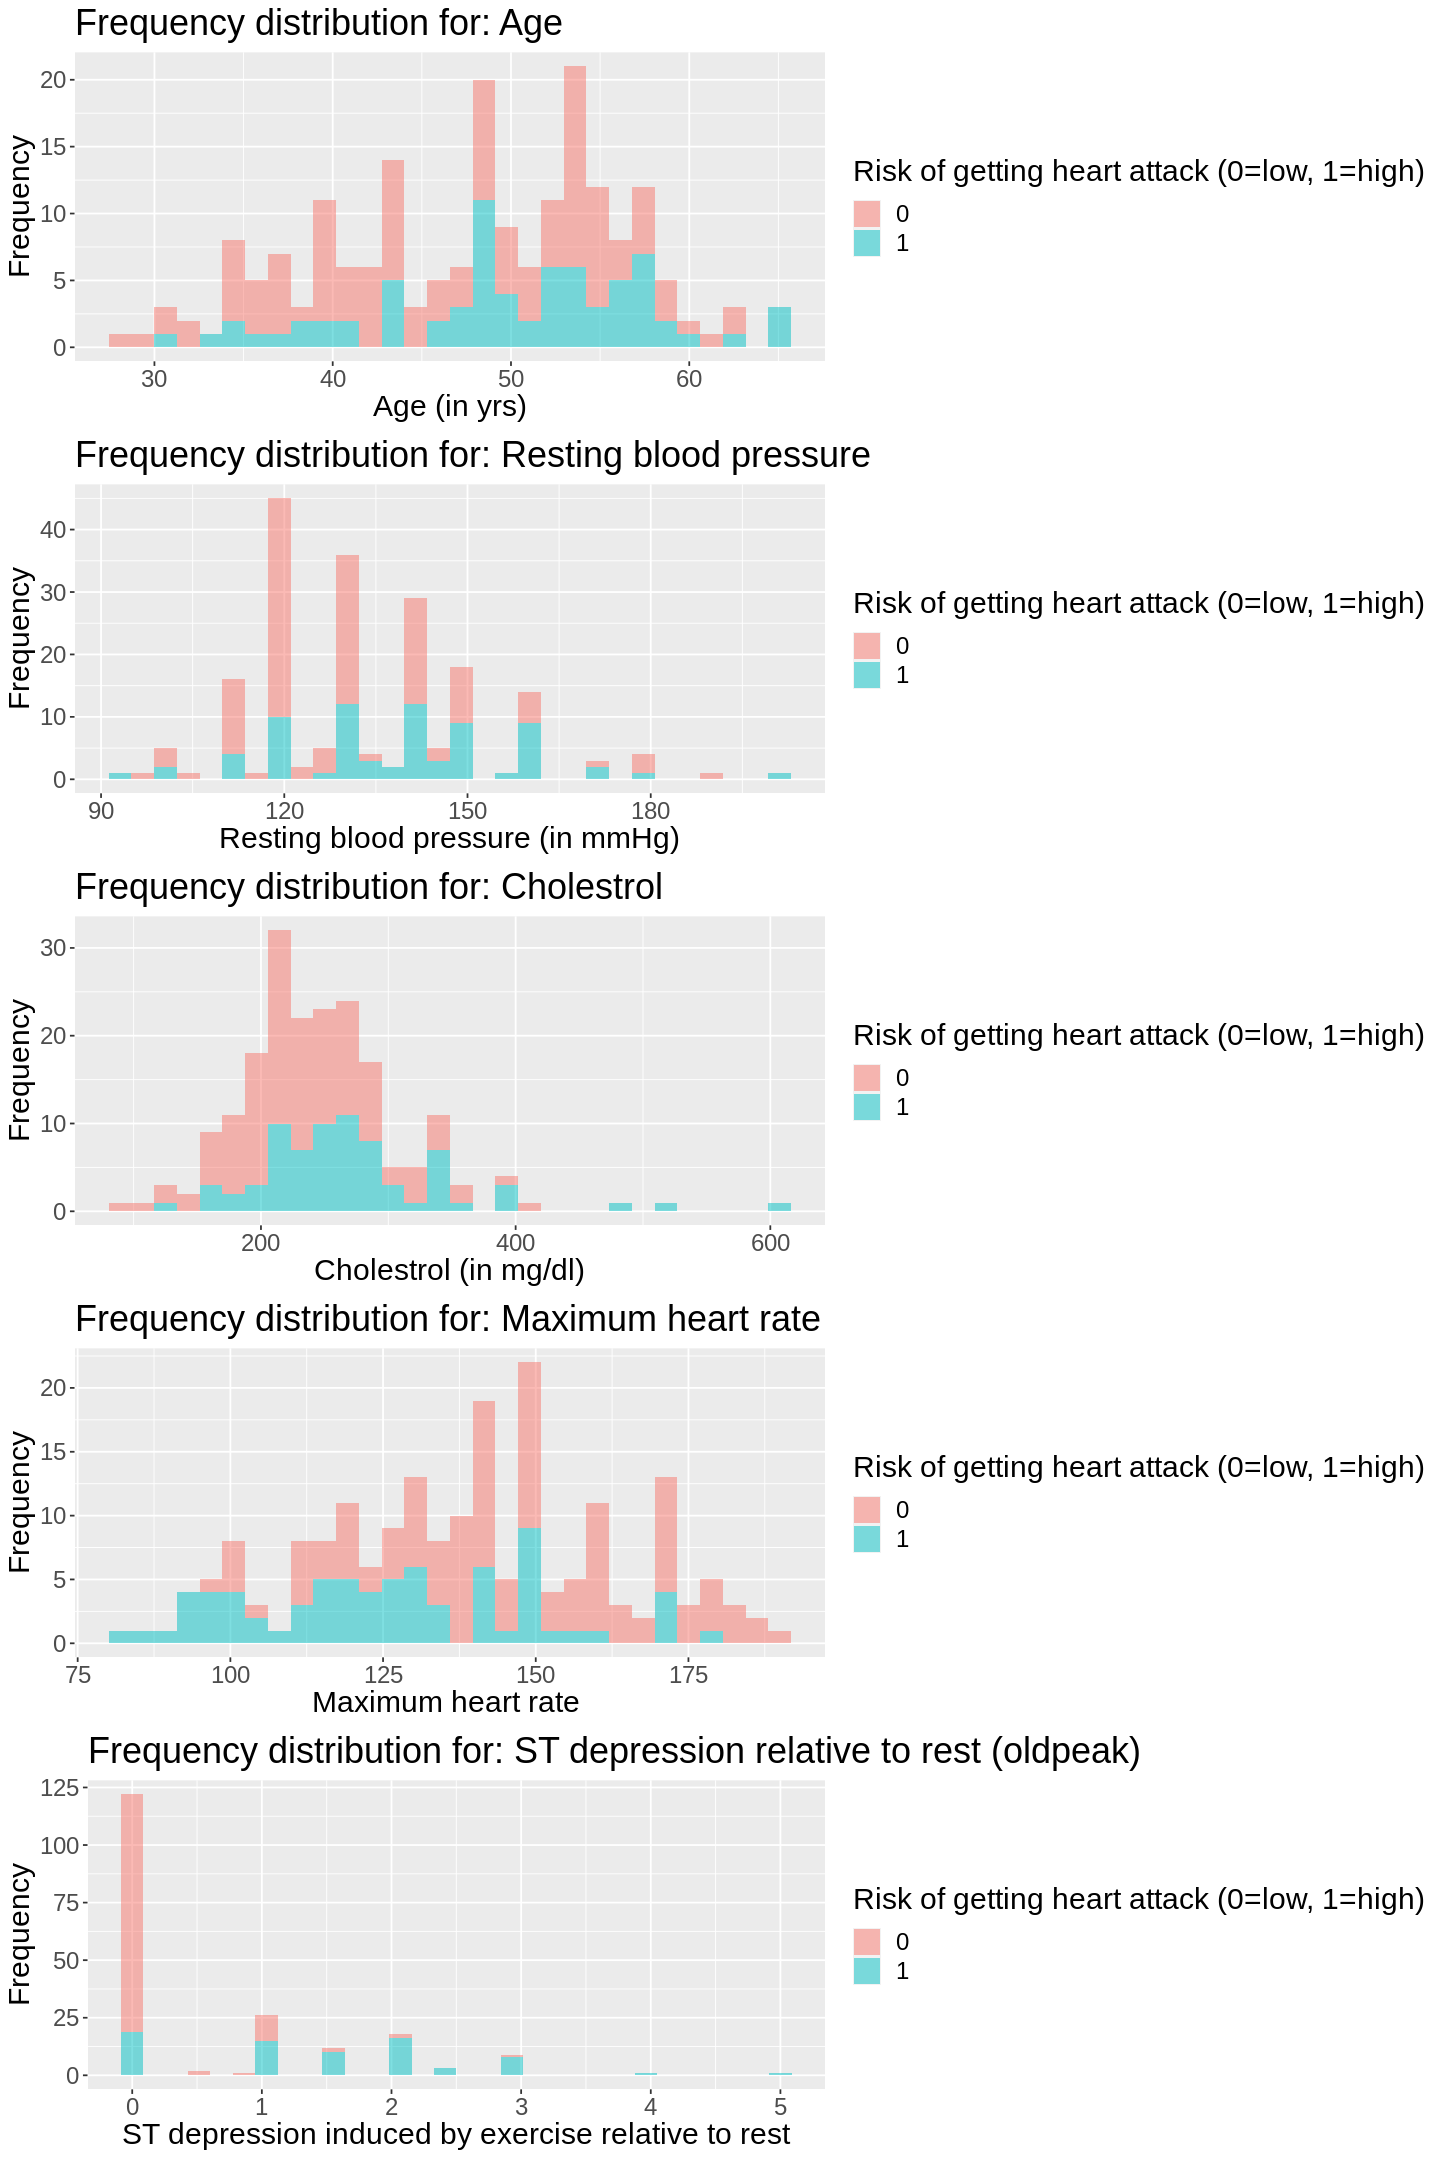

In [13]:
# age_hist = hist(raw_age,main="Histogram of age distribution",xlab="Age",ylab="Frequency")
# trestbps_hist = hist(raw_trestbps,main="Histogram of trestbps distribution",xlab="Age",ylab="Frequency")
# chol_hist = hist(raw_chol,main="Histogram of chol distribution",xlab="Age",ylab="Frequency")
# thalach_hist = hist(raw_thalach,main="Histogram of thalach distribution",xlab="Age",ylab="Frequency")
# oldpeak_hist = hist(raw_oldpeak,main="Histogram of oldpeak distribution",xlab="Age",ylab="Frequency")

options(repr.plot.width=12, repr.plot.height=18)

age_hist = heart_attack_data_selected |>
    ggplot(aes(x=age, fill=num))+
    geom_histogram(alpha=0.5,bins = 30)+
    labs(x = "Age (in yrs)", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: Age")+
    theme(text = element_text(size=18))

trestbps_hist = heart_attack_data_selected |>
    ggplot(aes(x=trestbps, fill=num))+
    geom_histogram(alpha=0.5,bins = 30)+
    labs(x = "Resting blood pressure (in mmHg)", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: Resting blood pressure")+
    theme(text = element_text(size=18))

chol_hist = heart_attack_data_selected |>
    ggplot(aes(x=chol, fill=num))+
    geom_histogram(alpha=0.5,bins = 30)+
    labs(x = "Cholestrol (in mg/dl)", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: Cholestrol")+
    theme(text = element_text(size=18))

thalach_hist = heart_attack_data_selected |>
    ggplot(aes(x=thalach, fill=num))+
    geom_histogram(alpha=0.5,bins = 30)+
    labs(x = "Maximum heart rate ", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: Maximum heart rate")+
    theme(text = element_text(size=18))

oldpeak_hist = heart_attack_data_selected |>
    ggplot(aes(x=oldpeak, fill=num))+
    geom_histogram(alpha=0.5,bins = 30)+
    labs(x = "ST depression induced by exercise relative to rest", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: ST depression relative to rest (oldpeak)")+
    theme(text = element_text(size=18))

plot_grid(age_hist, trestbps_hist, chol_hist, thalach_hist, oldpeak_hist, ncol=1)


Most of our histograms look like skewed normal distributions, but the last one (oldpeak) has more of a Boltzmann distribution.

### Methods

We choose these 5 variables as our predictors because all of them have the “double” type, so that the prediction will be more accurate compared to the factor type. 
* Age
* Resting blood pressure (trestbps)
* Cholesterol levels
* Maximum heart rate achieved (thalach)
* Old peak in ST depression (oldpeak)


Since our class (num) takes on only two values we will use K nearest neighbor classification analysis. One possible visualization is to make a line plot on how different K values affect prediction accuracy. We can also separate our scatter plots into 2 regions with different colors to mark each factor from our prediction result.

### Expected outcomes and significance

In doing our analysis, we expect to find correlations between each of the predictor variables and the risk of heart attack. We expect that for each predictor there will be a range of values for which the risk of heart attack is low, and the more that a predictor deviates from this range the more likely the given observation will have num = 1. We can use our visualizations above to help us with this analysis- for example, we can use the histograms to check where the risk of heart attack is lowest, and observe how the proportion of high and low risk changes as we move across a predictor's histogram.

Traditional methods of examination may not accurately predict if someone is at risk of heart failure. Our findings can help doctors make better informed decisions about a patient’s need for surgery and help save lives.

Some questions that might appear in the future regarding this prediction: 
* Are there any additional predictor variables to be added into consideration when predicting the risk of heart attack?
* Is the accuracy of this prediction high enough to be used in a real world situation?
